In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

import pandas as pd

In [11]:
# re upload files everytime run

from google.colab import files

uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [27]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

frames_X = [X_train, X_test]
frames_y = [y_train, y_test]

X = pd.concat(frames_X)
y = pd.concat(frames_y)

print(X.shape)
print(y.shape)

data_long = pd.melt(X, value_vars=['f(226.0000)','f(226.0000)','f(257.3256)','f(280.6155)','f(297.3018)','f(324.2099)','f(343.4884)','f(363.9133)','f(385.5527)','f(408.4789)','f(432.7683)','f(458.5020)','f(471.9372)','f(500.0000)','f(514.6511)','f(545.2539)','f(561.2310)','f(577.6763)','f(594.6036)','f(629.9605)','f(648.4198)','f(667.4199)','f(686.9768)','f(707.1068)','f(727.8266)','f(749.1535)','f(771.1054)','f(793.7005)','f(816.9577)','f(840.8964)','f(865.5366)','f(890.8987)','f(917.0040)','f(943.8743)','f(971.5319)','f(1000.0000)','f(1029.3022)','f(1059.4631)','f(1090.5077)','f(1122.4620)','f(1155.3527)','f(1189.2071)','f(1224.0535)','f(1259.9210)','f(1296.8396)','f(1334.8399)','f(1373.9536)','f(1414.2136)','f(1455.6532)','f(1498.3071)','f(1542.2108)','f(1587.4011)','f(1633.9155)','f(1681.7928)','f(1731.0731)','f(1781.7974)','f(1834.0081)','f(1887.7486)','f(1943.0639)','f(2000.0000)','f(2058.6045)','f(2118.9262)','f(2181.0155)','f(2244.9241)','f(2310.7054)','f(2378.4142)','f(2448.1071)','f(2519.8421)','f(2593.6791)','f(2669.6797)','f(2747.9073)','f(2828.4271)','f(2911.3064)','f(2996.6142)','f(3084.4217)','f(3174.8021)','f(3267.8309)','f(3363.5857)','f(3462.1462)','f(3563.5949)','f(3668.0162)','f(3775.4973)','f(3886.1278)','f(4000.0000)','f(4117.2089)','f(4237.8524)','f(4362.0309)','f(4489.8482)','f(4621.4108)','f(4756.8285)','f(4896.2142)','f(5039.6842)','f(5187.3582)','f(5339.3594)','f(5495.8146)','f(5656.8542)','f(5822.6127)','f(5993.2283)','f(6168.8433)','f(6349.6042)','f(6535.6618)','f(6727.1713)','f(6924.2925)','f(7127.1897)','f(7336.0323)','f(7550.9945)','f(7772.2555)','f(8000.0000)'],var_name='Frequency', value_name='WBA')
data_long['Frequency'] = data_long['Frequency'].str[2:-1].astype(float)
data = data_long.to_numpy()

norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

(191, 120)
(191, 1)
(48, 120)
(48, 1)
(239, 120)
(239, 1)


In [17]:
data = make_moons(3000, noise=0.05)[0].astype("float32")
norm = layers.Normalization()
norm.adapt(data)
normalized_data = norm(data)

In [30]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="selu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

In [31]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        )
        self.masks = np.array(
            [[0, 1], [1, 0]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(2) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.

        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

In [32]:
model = RealNVP(num_coupling_layers=6)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    normalized_data, batch_size=256, epochs=10, verbose=2, validation_split=0.2
)

Epoch 1/10
80/80 - 15s - loss: 1.6518 - val_loss: 14.8189 - 15s/epoch - 187ms/step
Epoch 2/10
80/80 - 9s - loss: 1.4187 - val_loss: 8.3384 - 9s/epoch - 113ms/step
Epoch 3/10
80/80 - 9s - loss: 1.3789 - val_loss: 8.9827 - 9s/epoch - 111ms/step
Epoch 4/10
80/80 - 9s - loss: 1.3140 - val_loss: 9.9168 - 9s/epoch - 111ms/step
Epoch 5/10
80/80 - 9s - loss: 1.2859 - val_loss: 12.7372 - 9s/epoch - 111ms/step
Epoch 6/10
80/80 - 9s - loss: 1.2833 - val_loss: 11.8915 - 9s/epoch - 112ms/step
Epoch 7/10
80/80 - 9s - loss: 1.3209 - val_loss: 20.9470 - 9s/epoch - 112ms/step
Epoch 8/10
80/80 - 10s - loss: 1.2898 - val_loss: 17.6141 - 10s/epoch - 128ms/step
Epoch 9/10
80/80 - 9s - loss: 1.2656 - val_loss: 15.5221 - 9s/epoch - 112ms/step
Epoch 10/10
80/80 - 9s - loss: 1.2594 - val_loss: 12.0742 - 9s/epoch - 110ms/step


(-2.0, 2.0)

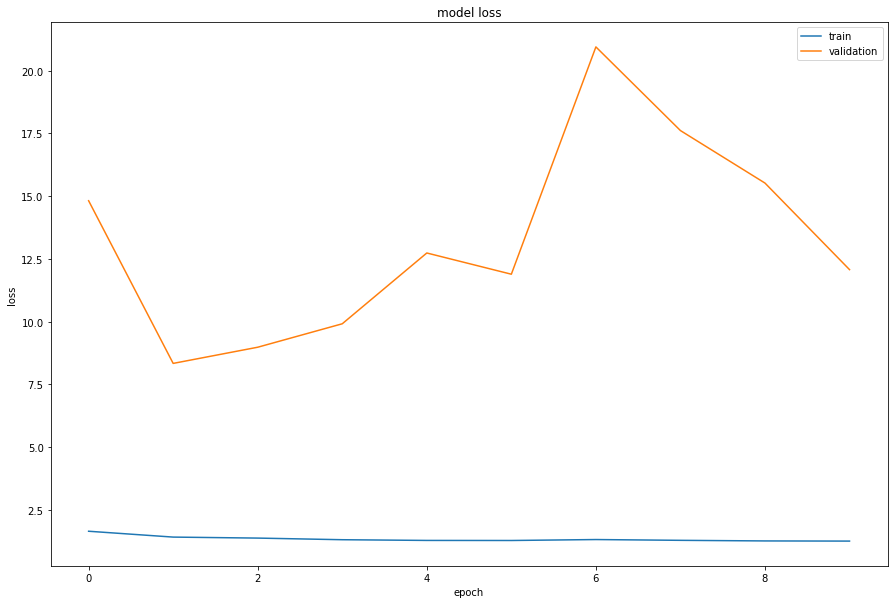

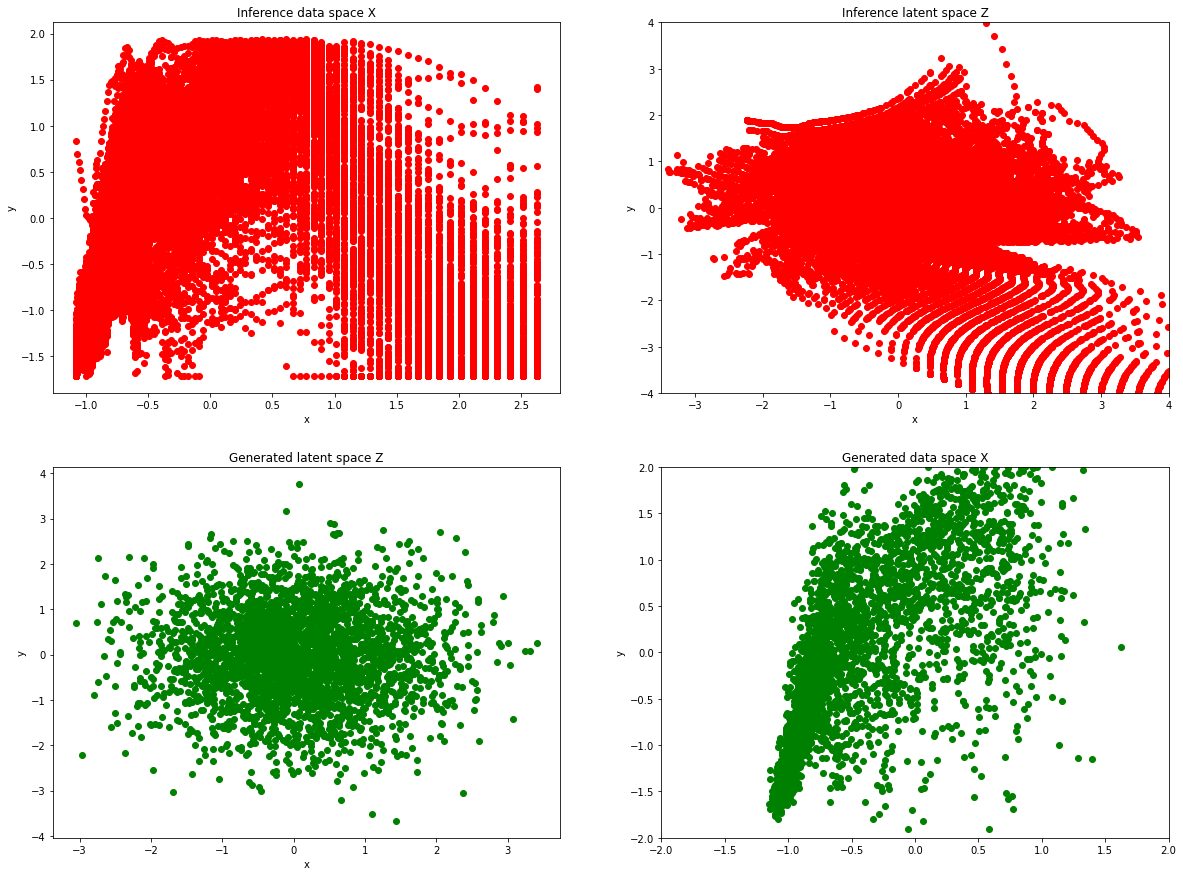

In [33]:
plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = model(normalized_data)

# From latent space to data.
samples = model.distribution.sample(3000)
x, _ = model.predict(samples)

f, axes = plt.subplots(2, 2)
f.set_size_inches(20, 15)

axes[0, 0].scatter(normalized_data[:, 0], normalized_data[:, 1], color="r")
axes[0, 0].set(title="Inference data space X", xlabel="x", ylabel="y")
axes[0, 1].scatter(z[:, 0], z[:, 1], color="r")
axes[0, 1].set(title="Inference latent space Z", xlabel="x", ylabel="y")
axes[0, 1].set_xlim([-3.5, 4])
axes[0, 1].set_ylim([-4, 4])
axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g")
axes[1, 0].set(title="Generated latent space Z", xlabel="x", ylabel="y")
axes[1, 1].scatter(x[:, 0], x[:, 1], color="g")
axes[1, 1].set(title="Generated data space X", label="x", ylabel="y")
axes[1, 1].set_xlim([-2, 2])
axes[1, 1].set_ylim([-2, 2])